In [1]:
import time
from glob import glob
from tqdm import tqdm
import pandas as pd
from utils import get_hour_crawl_df_lst, get_daily_origin_df_dict
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import numpy as np
from IPython.display import clear_output
from concurrent.futures import ProcessPoolExecutor
sns.set_palette("Set1", 7)
sns.color_palette("Set1", 7)

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392)]

In [2]:
sda_path = '/mnt/sda/tnecniv/tnecniv-2023/'
selected_weeks = sorted(glob(sda_path+'*-*'))[5:7]
ten_min_csvs = [w for week in selected_weeks for w in sorted(glob(week+'/*-*.csv'))]
ten_min_csvs = [ten_min_csvs[24*i:24*(i+1)] for i in range(len(selected_weeks)*7)]
date = [c[0].split('/')[-1][:6] for c in ten_min_csvs]
origin_df_lst = [pd.read_csv(week+'/origin.csv', names=['user_login', 'origin', 'origin_fetch_time'])[['user_login', 'origin']] for week in sorted(glob(sda_path+'*-*'))[4:5]+selected_weeks]

for i, df in enumerate(origin_df_lst):
    if(i == 0): continue
    origin_df_lst[i] = pd.merge(origin_df_lst[i] , origin_df_lst[i-1], how='outer').drop_duplicates(subset='user_login')
del origin_df_lst[0]
origin_dict = {d:origin_df_lst[i//7] for i, d in enumerate(date)}

In [3]:
full_language_names = {
    'en': 'English', 'es': 'Spanish', 'pt': 'Portuguese', 'ru': 'Russian', 'de': 'German', 'fr': 'French', 'ja': 'Japanese', 'zh': 'Chinese', 'pl': 'Polish', 'it': 'Italian', 'tr': 'Turkish', 'th': 'Thai', 'ar': 'Arabic', 'cs': 'Czech', 'ko': 'Korean'
}


In [4]:
origin_names = ['ams04', 'muc03', 'cmh01', 'iad06', 'pdx05', 'lhr05', 'sin03', '']
language_names = ['en', 'es', 'pt', 'ru', 'fr', 'de', 'ja', 'ko', 'zh', 'it', 'tr', 'pl', 'th', 'ar', 'cs', 'other', 'hu', 'nl', 'uk', 'sv', 'fi', 'el', 'da', 'bg', 'tl', 'no', 'ro', 'sk', 'id', 'zh-hk', 'ca', 'vi', 'hi', 'asl', 'ms', '']
sc_result_dict = {(o, l): [] for o in origin_names for l in language_names}
vc_result_dict = {(o, l): [] for o in origin_names for l in language_names}
ori_lang_pair = [(o, l) for o in origin_names for l in language_names]


In [5]:
def get_old_ol_results(day_csvs):
    sc_result = {(o, l): [] for o in origin_names for l in language_names}
    vc_result = {(o, l): [] for o in origin_names for l in language_names}
    day = day_csvs[0].split('/')[-1][:6]
    for csv in day_csvs:
        df_lst = get_hour_crawl_df_lst(csv, origin_dict[day])
        for df in df_lst:
            sc_res = df[['user_login', 'origin', 'language']].groupby(['origin', 'language']).count().to_dict()['user_login']
            vc_res = df[['viewer_count', 'origin', 'language']].groupby(['origin', 'language']).sum().to_dict()['viewer_count']
            for ol_pair in ori_lang_pair:
                try:
                    sc_result[ol_pair].append(sc_res[ol_pair])
                except:
                    sc_result[ol_pair].append(0)
                try:
                    vc_result[ol_pair].append(vc_res[ol_pair])
                except:
                    vc_result[ol_pair].append(0)
    return sc_result, vc_result

In [6]:
with ProcessPoolExecutor(max_workers=5) as executor:
    for sc, vc in executor.map(get_old_ol_results, ten_min_csvs):
        for o in origin_names:
            for l in language_names:
                sc_result_dict[(o, l)].extend(sc[(o, l)])
                vc_result_dict[(o, l)].extend(vc[(o, l)])
print('finished')

finished


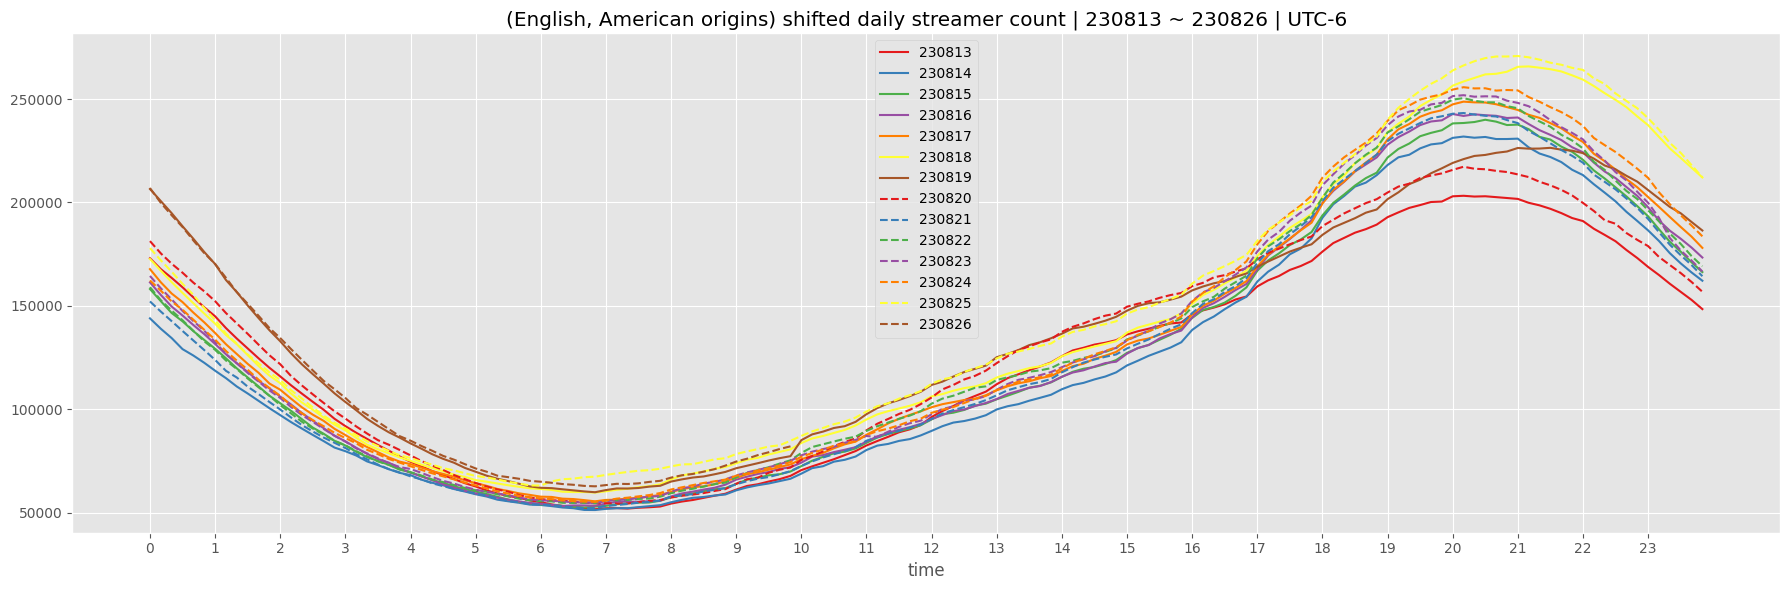

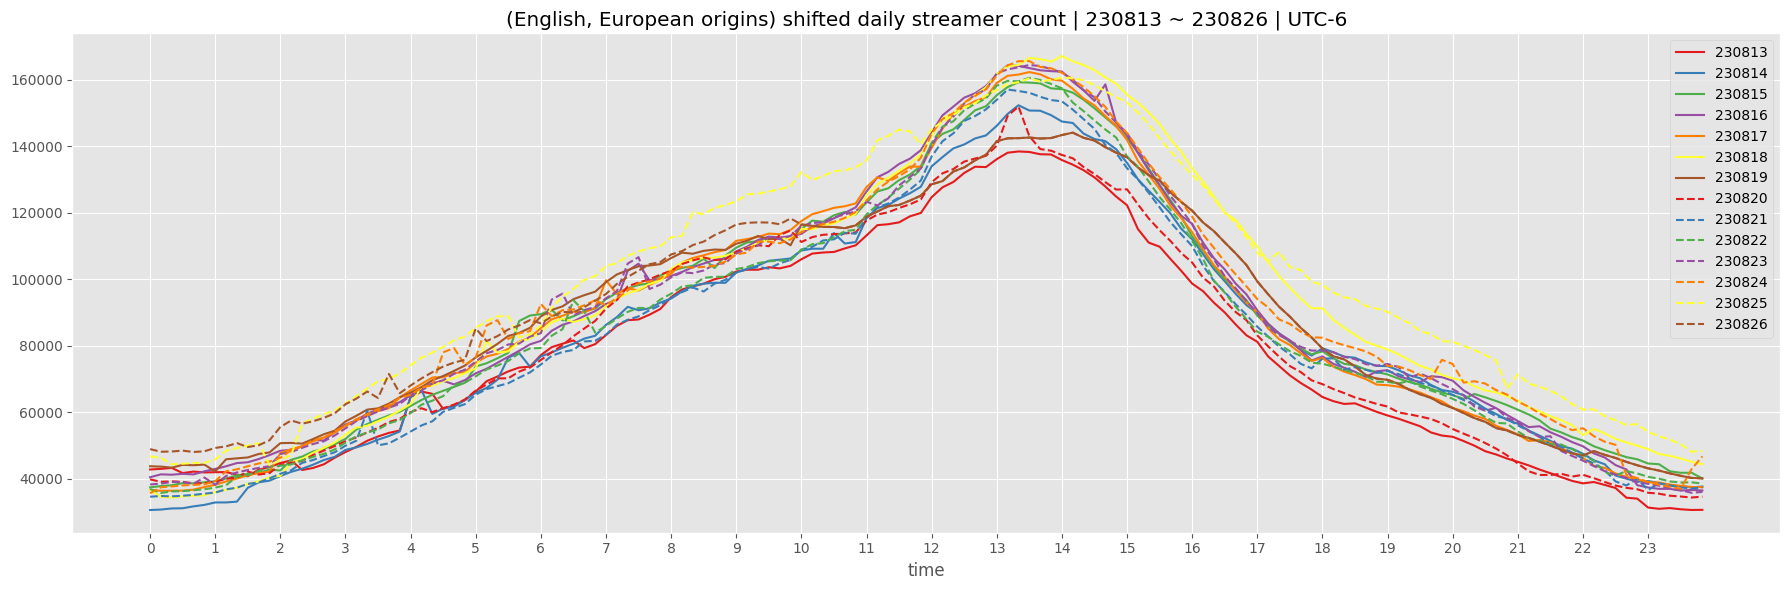

In [7]:
lang = 'en'
tz = -6
no_days = len(date)
fig, ax = plt.subplots(1, figsize=(18, 6))
tmp = np.zeros(144 * no_days)
for i, ori in enumerate(['cmh01', 'iad06', 'pdx05']):
    for j in range(7):
        tmp += sc_result_dict[(ori, lang)]
for j in range(no_days):
    ax.plot(tmp[144*j+(8-tz)*6:144*(j+1)+(8-tz)*6], label=date[j],
    linestyle='solid' if j<7 else 'dashed')
    ax.set_xticks(np.arange(0, 144, 6), range(24))
ax.set_title(f"({full_language_names[lang]}, American origins) shifted daily streamer count | {date[0]} ~ {date[-1]} | UTC{tz:+}")
ax.set_xlabel("time")
fig.tight_layout()
ax.legend()
plt.show()

fig, ax = plt.subplots(1, figsize=(18, 6))
tmp = np.zeros(144 * no_days)
for i, ori in enumerate(['ams04', 'muc03', 'lhr05']):
    for j in range(no_days):
        tmp += sc_result_dict[(ori, lang)]
for j in range(no_days):
    if(j == no_days-1):
        ax.plot(np.concatenate([tmp[144*j+(8-tz)*6:], tmp[144*7:144*7+(8-tz)*6]]), label=date[j], linestyle='solid' if j<7 else 'dashed')
    else:
        ax.plot(tmp[144*j+(8-tz)*6:144*(j+1)+(8-tz)*6], label=date[j], linestyle='solid' if j<7 else 'dashed')
    ax.set_xticks(np.arange(0, 144, 6), range(24))
ax.set_title(f"({full_language_names[lang]}, European origins) shifted daily streamer count | {date[0]} ~ {date[-1]} | UTC{tz:+}")

ax.set_xlabel("time")
fig.tight_layout()
ax.legend()
plt.show()

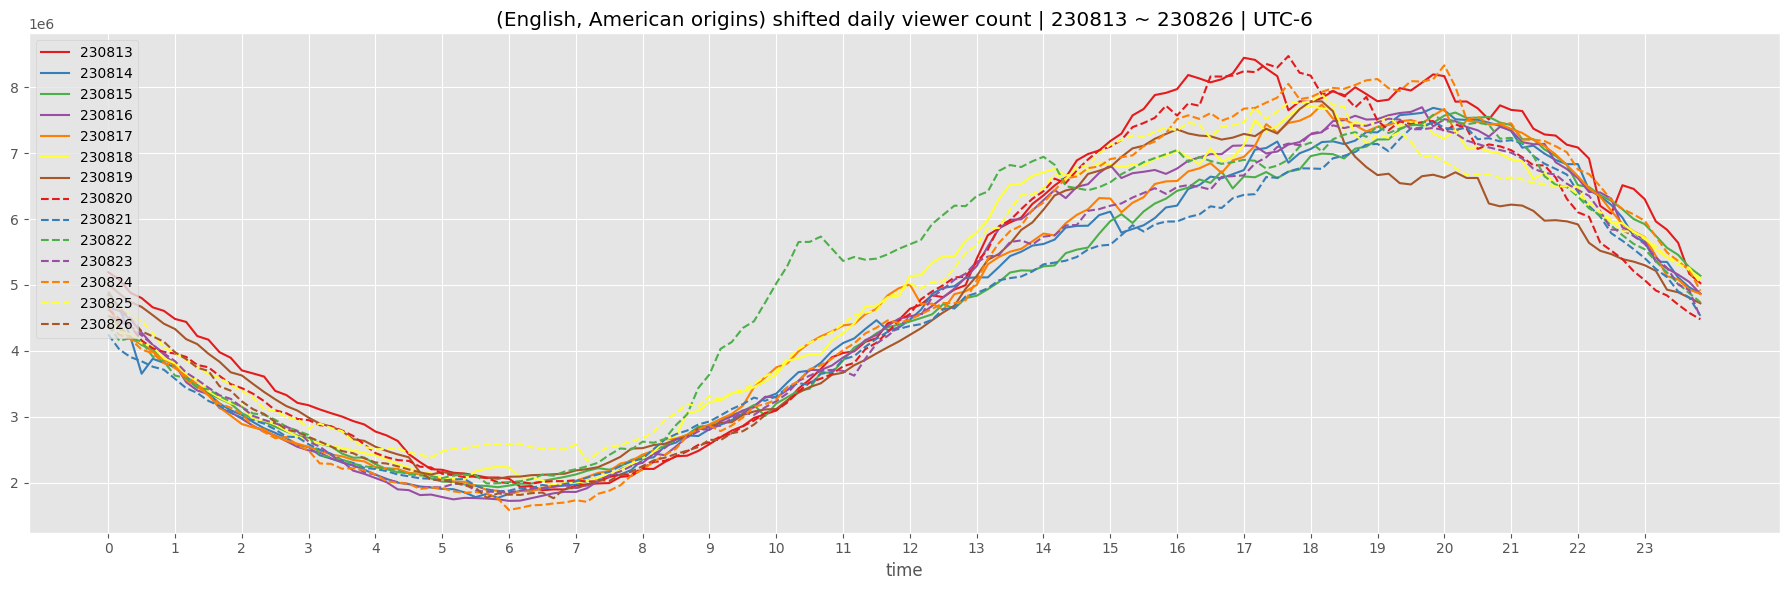

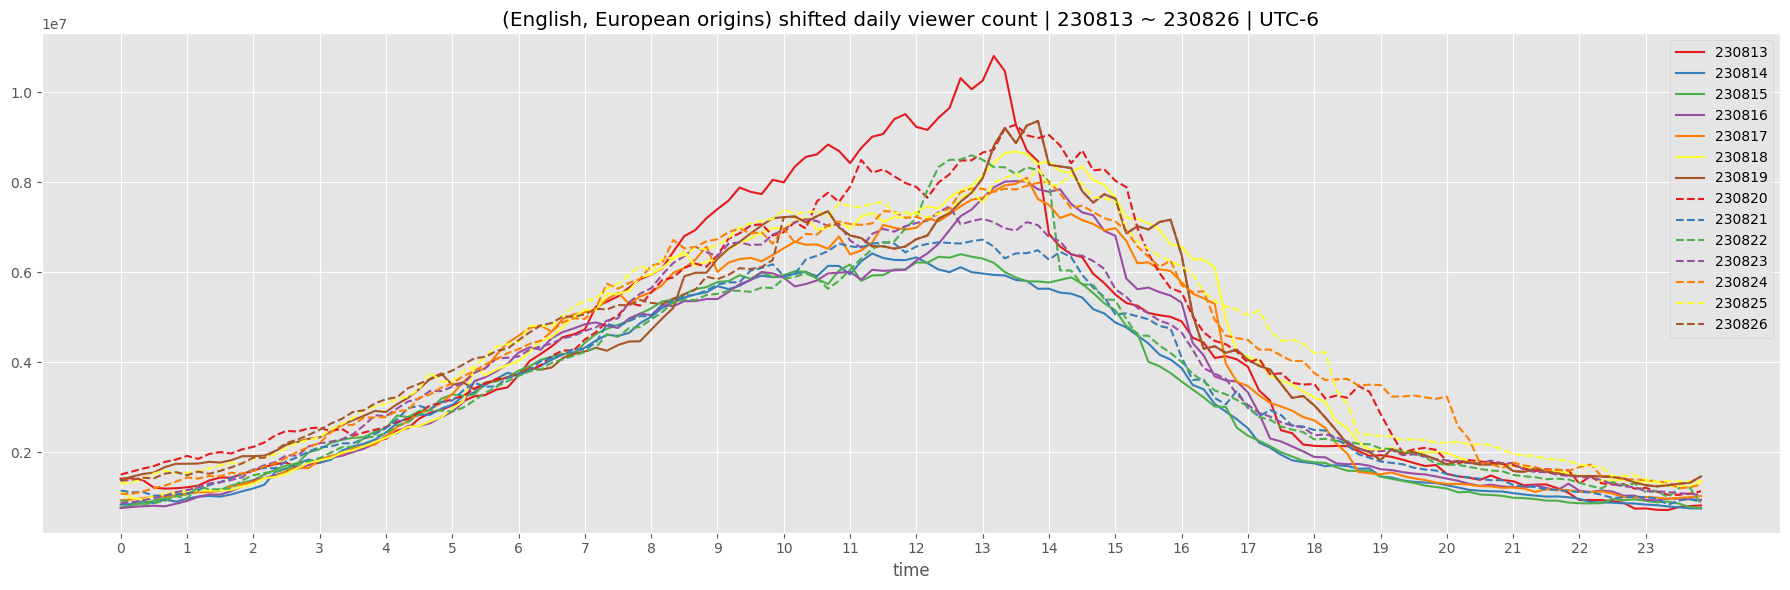

In [8]:
lang = 'en'
tz = -6
no_days = len(date)
fig, ax = plt.subplots(1, figsize=(18, 6))
tmp = np.zeros(144 * no_days)
for i, ori in enumerate(['cmh01', 'iad06', 'pdx05']):
    for j in range(7):
        tmp += vc_result_dict[(ori, lang)]
for j in range(no_days):
    ax.plot(tmp[144*j+(8-tz)*6:144*(j+1)+(8-tz)*6], label=date[j],
    linestyle='solid' if j<7 else 'dashed')
    ax.set_xticks(np.arange(0, 144, 6), range(24))
ax.set_title(f"({full_language_names[lang]}, American origins) shifted daily viewer count | {date[0]} ~ {date[-1]} | UTC{tz:+}")
ax.set_xlabel("time")
fig.tight_layout()
ax.legend()
plt.show()

fig, ax = plt.subplots(1, figsize=(18, 6))
tmp = np.zeros(144 * no_days)
for i, ori in enumerate(['ams04', 'muc03', 'lhr05']):
    for j in range(no_days):
        tmp += vc_result_dict[(ori, lang)]
for j in range(no_days):
    if(j == no_days-1):
        ax.plot(np.concatenate([tmp[144*j+(8-tz)*6:], tmp[144*7:144*7+(8-tz)*6]]), label=date[j], linestyle='solid' if j<7 else 'dashed')
    else:
        ax.plot(tmp[144*j+(8-tz)*6:144*(j+1)+(8-tz)*6], label=date[j], linestyle='solid' if j<7 else 'dashed')
    ax.set_xticks(np.arange(0, 144, 6), range(24))
ax.set_title(f"({full_language_names[lang]}, European origins) shifted daily viewer count | {date[0]} ~ {date[-1]} | UTC{tz:+}")

ax.set_xlabel("time")
fig.tight_layout()
ax.legend()
plt.show()

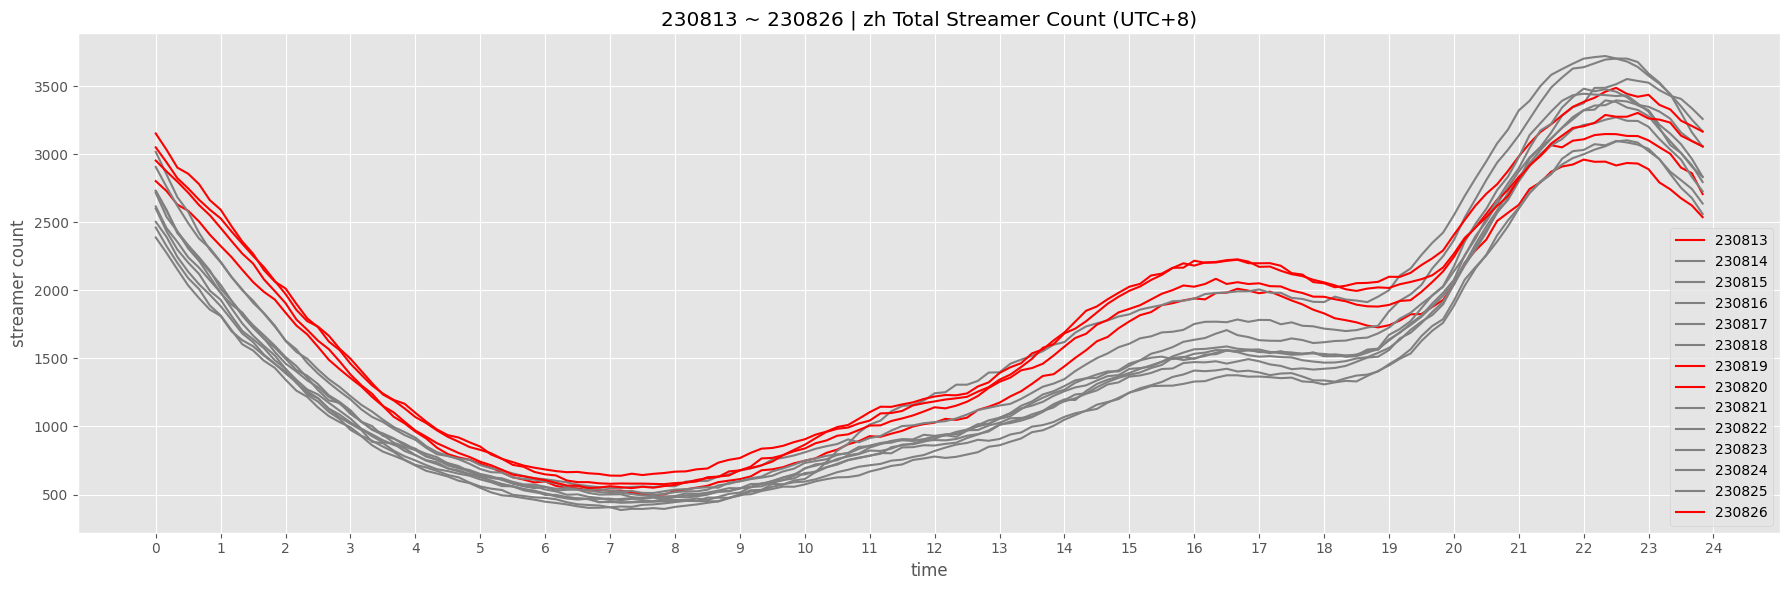

In [9]:
lang = 'zh'
no_days = len(date)
fig, ax = plt.subplots(1, figsize=(18, 6))
tmp = np.zeros((144, no_days))
for i, ori in enumerate(origin_names):
    for j in range(no_days):
        tmp[:, j] += sc_result_dict[(ori, lang)][144*j:144*(j+1)]
for j in range(no_days):
    lc = 'red' if j in [0, 6, 7, 13] else 'gray'
    ax.plot(tmp[:, j], label=date[j], c=lc,)
    ax.set_xticks(np.arange(0, 145, 6), range(25))
ax.set_title(f"{date[0]} ~ {date[-1]} | {lang} Total Streamer Count (UTC+8)")
ax.set_ylabel("streamer count")
ax.set_xlabel("time")
fig.tight_layout()
ax.legend()
plt.show()

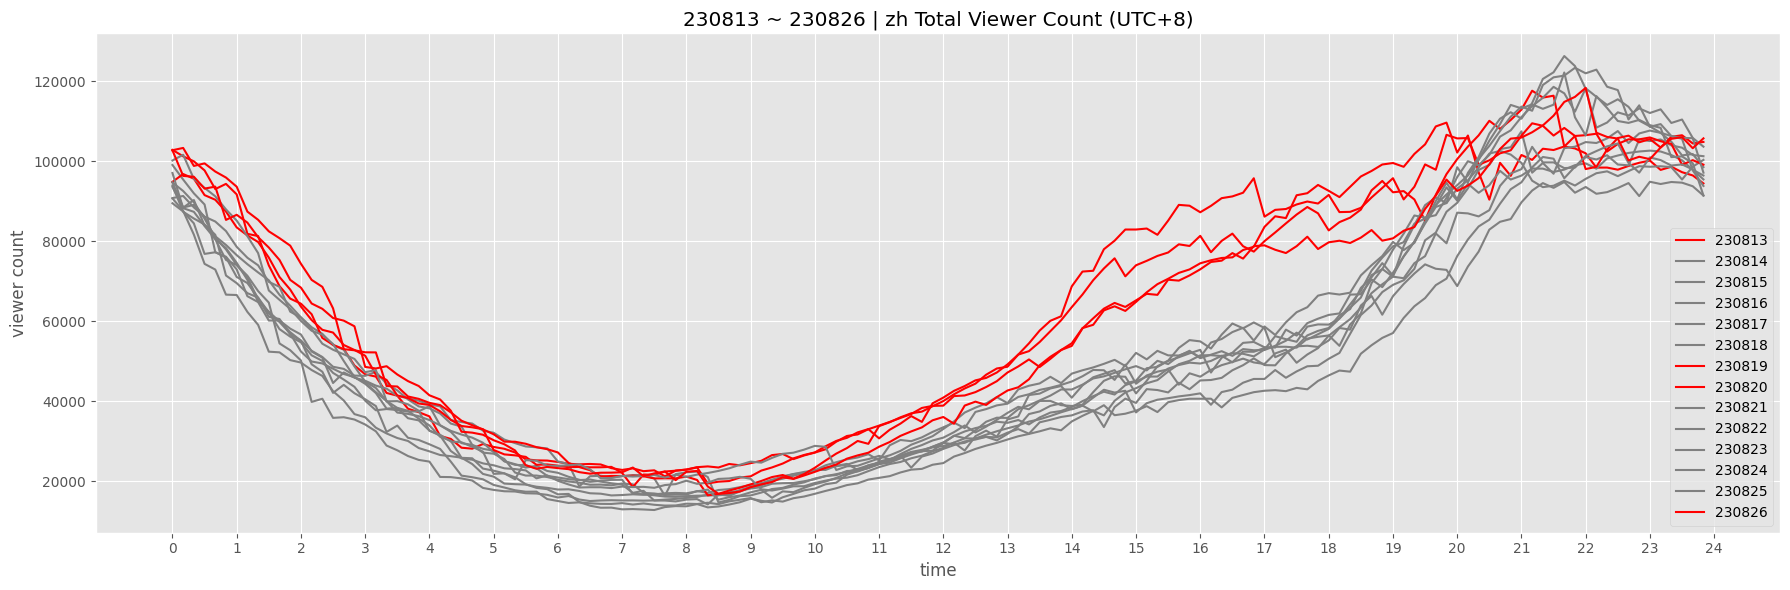

In [10]:
lang = 'zh'
no_days = len(date)
fig, ax = plt.subplots(1, figsize=(18, 6))
tmp = np.zeros((144, no_days))
for i, ori in enumerate(origin_names):
    for j in range(no_days):
        tmp[:, j] += vc_result_dict[(ori, lang)][144*j:144*(j+1)]
for j in range(no_days):
    lc = 'red' if j in [0, 6, 7, 13] else 'gray'
    ax.plot(tmp[:, j], label=date[j], c=lc,)
    ax.set_xticks(np.arange(0, 145, 6), range(25))
ax.set_title(f"{date[0]} ~ {date[-1]} | {lang} Total Viewer Count (UTC+8)")
ax.set_ylabel("viewer count")
ax.set_xlabel("time")
fig.tight_layout()
ax.legend()
plt.show()

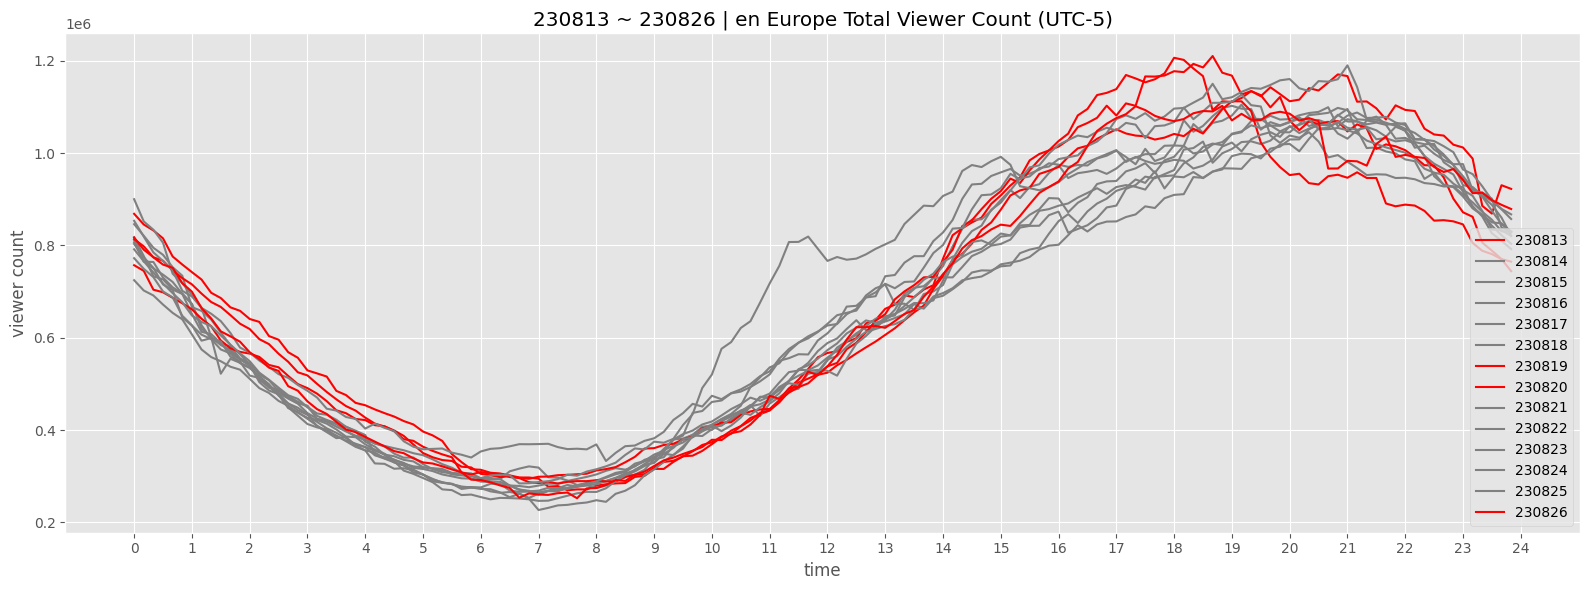

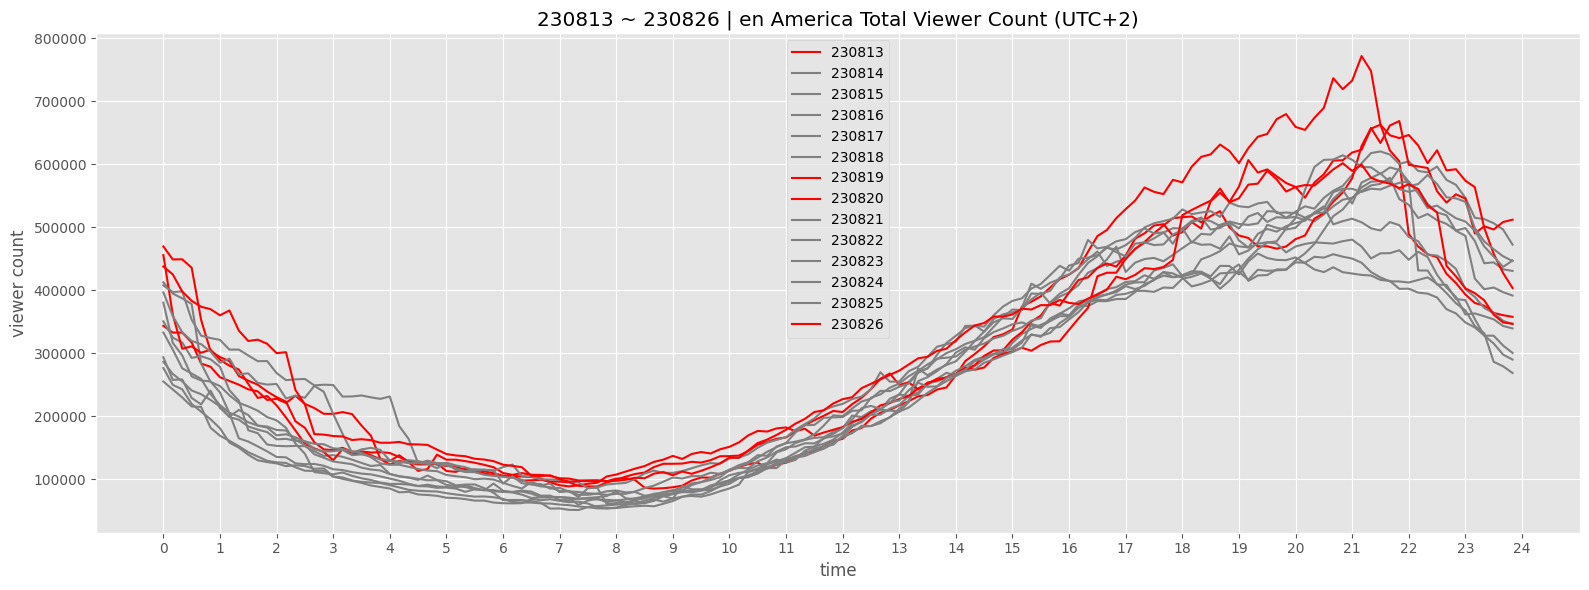

In [11]:
tz = -5
lang = 'en'
no_days = len(date)
fig, ax = plt.subplots(1, figsize=(16, 6))
tmp = np.zeros((144, no_days))
for i, ori in enumerate(['cmh01', 'iad06', 'pdx05']):
    for j in range(no_days):
        tmp[:, j] += vc_result_dict[(ori, lang)][144*j:144*(j+1)]

tmp = np.roll(tmp.flatten('F'), -6*(8-tz), axis=0).reshape((no_days, 144)).T

for j in range(no_days):
    lc = 'red' if j in [0, 6, 7, 13] else 'gray'
    ax.plot(tmp[:, j], label=date[j], c=lc)
    ax.set_xticks(np.arange(0, 145, 6), range(25))

ax.set_title(f"{date[0]} ~ {date[-1]} | {lang} Europe Total Viewer Count (UTC{tz})")
ax.set_ylabel("viewer count")
ax.set_xlabel("time")
fig.tight_layout()
ax.legend()
plt.show()

tz = 2
fig, ax = plt.subplots(1, figsize=(16, 6))
tmp = np.zeros((144, no_days))
for i, ori in enumerate(['ams04', 'muc03', 'lhr05']):
    for j in range(no_days):
        tmp[:, j] += vc_result_dict[(ori, lang)][144*j:144*(j+1)]

tmp = np.roll(tmp.flatten('F'), -6*(8-tz), axis=0).reshape((no_days, 144)).T

for j in range(no_days):
    lc = 'red' if j in [0, 6, 7, 13] else 'gray'
    ax.plot(tmp[:, j], label=date[j], c=lc)
    ax.set_xticks(np.arange(0, 145, 6), range(25))

ax.set_title(f"{date[0]} ~ {date[-1]} | {lang} America Total Viewer Count (UTC+{tz})")
ax.set_ylabel("viewer count")
ax.set_xlabel("time")
fig.tight_layout()
ax.legend()
plt.show()

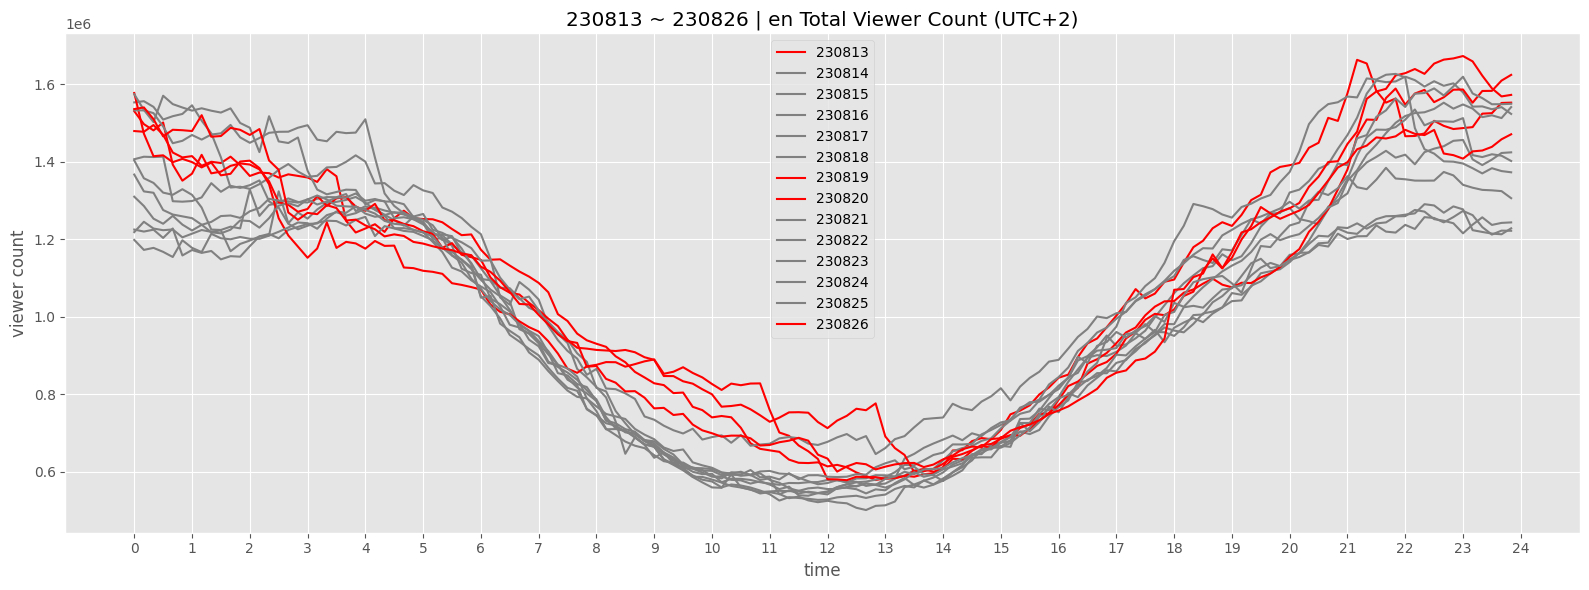

In [12]:
tz = 2
lang = 'en'
no_days = len(date)
fig, ax = plt.subplots(1, figsize=(16, 6))
tmp = np.zeros((144, no_days))
for i, ori in enumerate(origin_names):
    for j in range(no_days):
        tmp[:, j] += vc_result_dict[(ori, lang)][144*j:144*(j+1)]

tmp = np.roll(tmp.flatten('F'), -6*(8-tz), axis=0).reshape((no_days, 144)).T

for j in range(no_days):
    lc = 'red' if j in [0, 6, 7, 13] else 'gray'
    ax.plot(tmp[:, j], label=date[j], c=lc)
    ax.set_xticks(np.arange(0, 145, 6), range(25))

ax.set_title(f"{date[0]} ~ {date[-1]} | {lang} Total Viewer Count (UTC+{tz})")
ax.set_ylabel("viewer count")
ax.set_xlabel("time")
fig.tight_layout()
ax.legend()
plt.show()

In [13]:
origin_df_lst[0].groupby('origin').count()

,user_login
origin,
ams04,98579
cmh01,150814
iad06,108159
lhr05,86943
muc03,116458
pdx05,122607
sin03,104249
